In [2]:
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
import numpy as np
from salishsea_tools import tidetools
from salishsea_tools import (nc_tools,viz_tools,bathy_tools)
import matplotlib.cm as cm
import os
%matplotlib inline
mpl.rcParams.update({'font.size': 12})
mpl.rcParams["axes.formatter.useoffset"] = False

In [3]:
grid1 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc','r')

In [4]:
f1 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane\
/result/14_NW_deepen/ariane_trajectories_qualitative.nc','r')
f2 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane\
/result/default/ariane_trajectories_qualitative.nc','r')

In [5]:
def compare_tracks_more(f1,f2,grid1,grid2,i):
    """This function was made to compare particle trajectories
        between nowcasts & deepened case and nowcasts with same 
        TS initial & deepended case
        f1: deepened case
        f2: nowcasts 
        f3: nowcasts with same TS for deepend case
        return the figure"""
    fig, axs = plt.subplots(1,1,figsize=(6,6))
    n = np.arange(2)
    #grid = [grid1, grid2]
    colors = cm.rainbow(np.linspace(0, 1, len(n)))
    legd = ['new', 'nowcast']
    ## for first comparison
    f = [f1,f2]
    for ff, le, c in zip(f, legd, colors):
        lont = ff.variables['traj_lon']
        latt = ff.variables['traj_lat']
        dept = ff.variables['traj_depth']
        xs = ff.variables['init_x']
        ys = ff.variables['init_y']
        t = ff.variables['traj_time']
        axs.scatter(lont[1:,i],latt[1:,i],color=c, label = le)
        axs.scatter(lont[0,i],latt[0,i],color='0.30',marker='s')
        axs.legend(loc = 2)
        viz_tools.plot_land_mask(axs, grid1, coords='map')
        viz_tools.plot_coastline(axs,grid1,coords='map', isobath=5)
        axs.set_xlim([-123.8,-122.8])
        axs.set_ylim([48.5,49.4])
        axs.set_xlabel('Longitude')
        axs.set_ylabel('Latitude')
    return fig

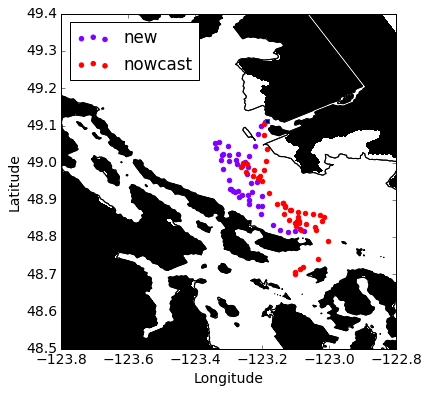

In [6]:
mpl.rcParams.update({'font.size': 14})
fig = compare_tracks_more(f1,f2, grid1,grid2, 0)

# Drifter

In [7]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy, X, Y = tidetools.get_bathy_data(grid)
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']
bath = grid.variables['Bathymetry']

In [8]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']

In [9]:
def plotoct_mewold(lon,lat,part,start,end,start_d,end_d,day,hour,minute,duration):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    viz_tools.plot_coastline(axs,grid,coords='map')
    viz_tools.plot_coastline(axs,grid,coords='map',isobath=4,color='DarkViolet')
    viz_tools.plot_coastline(axs,grid,coords='map',isobath=20,color='OrangeRed')
    axs.set_xlim([-123.6,-123])
    axs.set_ylim([48.8,49.4])
    axs.set_xticks([-123.6, -123.4, -123.2,-123])
    axs.set_xticklabels([-123.6, -123.4, -123.2,-123])
    axs.set_xlabel('Longitude')
    axs.set_ylabel('Latitude')
    
    colors=['DodgerBlue','Olive']
    for i, key in enumerate(lon.keys()):
        axs.scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[i],label=key)
        axs.scatter(lon[key][0,part],lat[key][0,part],color='0.30',marker='s')
    axs.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5, fancybox=False, shadow=True)
    
    return fig

In [10]:
drop = 'drop1/12'
runs=['oct8_10reduceviscosity','oct8_101e061e05']
strings = ['LowerVisco','LowerBoth']
base='/ocean/jieliu/research/meopar/Ariane/result/'
file_pattern = 'ariane_trajectories_qualitative.nc'
lon112 = {}; lat112={}
for run, string in zip(runs,strings):
    path = os.path.join(base,run, drop,file_pattern)
    f = nc.Dataset(path,'r');
    lon112[string] = f.variables['traj_lon']
    lat112[string] = f.variables['traj_lat']

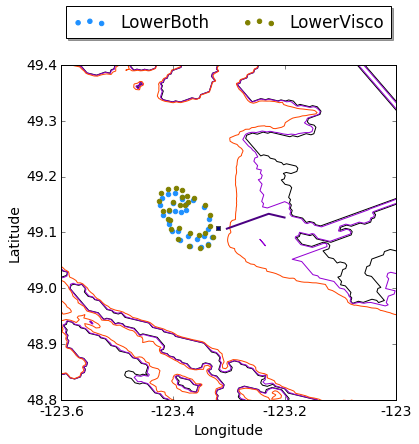

In [11]:
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)

# Salinity stuff

In [11]:
import sys
sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import salinity3
import datetime
import scipy.io as sio
import numpy as np
import netCDF4 as nc
import matplotlib.gridspec as gridspec

In [12]:
paths = {'nowcast': '/data/jieliu/MEOPAR/river-treatment/oct8_10nowcast/',
        'deepenresult': '/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/',
        'reduced_viscosity': '/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/',
        'all_reduced': '/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/',
        'jetty': '/data/jieliu/MEOPAR/river-treatment/oct8_10jetty1e0605/'}

In [25]:
def salinity_plot_test(run_date, saline, run_lower, run_upper, path_ssh,t):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_deep, value_mean_4rd_deep, \
    value_mean_avedeep, value_mean_ave4deep,\
    salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn\
    (saline, run_date, paths['deepenresult'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_nowcast, value_mean_4rd_nowcast, \
    value_mean_ave3nowcast, value_mean_ave4nowcast,\
    salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn\
    (saline, run_date, paths['nowcast'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_redu, value_mean_4rd_redu, \
    value_mean_averedu, value_mean_ave4redu,\
    salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn\
    (saline, run_date, paths['reduced_viscosity'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_allredu, value_mean_4rd_allredu, \
    value_mean_aveallredu, value_mean_ave4allredu,\
    salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn\
    (saline, run_date, paths['all_reduced'],run_lower,run_upper)
    

    fig = plt.figure(figsize=(16,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    gs.update(wspace=0.17, hspace=0.3)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    titles = '1.5 m Salinity ';
    nowcast = [value_mean_3rd_nowcast, value_mean_ave3nowcast];
    deep = [value_mean_3rd_deep, value_mean_avedeep];
    redu = [value_mean_3rd_redu, value_mean_averedu];
    allredu = [value_mean_3rd_allredu, value_mean_aveallredu];

    ## 1.5m salinity comparison
    model_3rd_nowcast=ax0.plot(lon_model,value_mean_3rd_nowcast,'DodgerBlue',\
                                        linewidth=2, label='nowcast')
    model_3rd_deep=ax0.plot(lon_model,value_mean_3rd_deep,'MediumBlue',\
                                            linewidth=2, label="deepened" )
    model_3rd_redu=ax0.plot(lon_model,value_mean_3rd_redu,'tomato',\
                                            linewidth=2, label="reduced_viscosity" )
    model_3rd_allredu=ax0.plot(lon_model,value_mean_3rd_allredu,'Indigo',\
                                            linewidth=2, label="all_redu" )

    observation_salinity=ax0.plot(lon1_model,salinity1_2_4,'DarkGreen', \
                                         linewidth=2, label="Observed")

    ax = ax0
    ax.set_xlim(-124, -123)
    ax.set_ylim(10, 32)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Practical Salinity')
    ax.legend(loc = 3)
    ax.grid('on')
    ax.set_title(titles + date_str)
    #plt.setp(ax.get_xticklabels())
    #plt.setp(ax.get_yticklabels())

    ## add ssh plot
    ssh,tt, hour = salinity3.get_ssh_in_model(run_date, path_ssh,t)
    ax1.plot(tt[:],ssh[:, 466,329],'-k', linewidth = 2.5)
    ax1.plot(tt[t],ssh[t, 466,329], color = 'Maroon',marker='*', markersize = 14)
    ax1.grid('on')
       

    ax1.set_xlabel('Time [utc]')
    ax1.set_ylabel('Water level (m)')
    #plt.setp(ax1.get_xticklabels())
    #plt.setp(ax1.get_yticklabels())
    return fig 

In [14]:
run_date = datetime.datetime(2014,10,8)
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141007.mat')

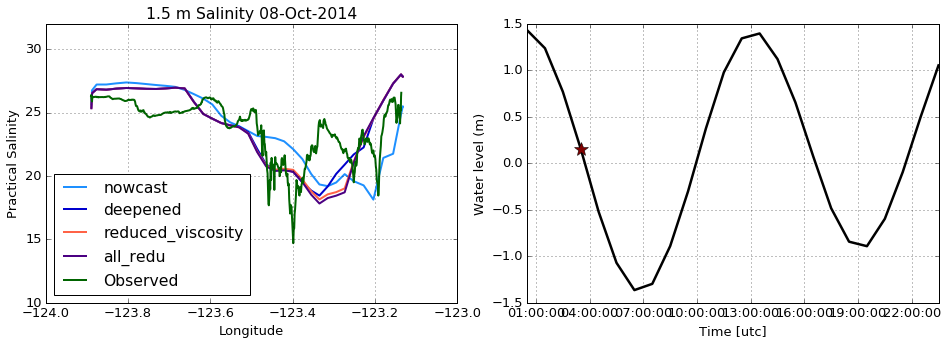

In [26]:
mpl.rcParams.update({'font.size': 13})
run_lower = run_date.replace(hour = 3, minute = 0)
run_upper = run_date.replace(hour = 5, minute =15)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['deepenresult'],3)

# Statistics

In [31]:
def min_salinity_test(results_home):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    days = [7,8,9];sal_min_obs = [np.nan]; lon_obs = [np.nan];sal_min_15 = [np.nan];lon_15=[np.nan];
    for day in days:
        for i in np.arange(24):
            if i < 12:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE192014100%s.mat' %(day))
            elif i>=12 and day!=9:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE192014100%s.mat' %(day+1))
            elif i>=12 and day ==9:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE19201410%s.mat' %(day+1))
            ## read in run_date, run_lower and run_upper for each trip case.
            run_date = datetime.datetime(2014,10,day+1)
            if i == 0 or i==14 or i==16 or i==21:
                run_lower = run_date.replace(hour = i, minute = 45)
                if i ==14:
                    run_upper = run_lower.replace(hour = i+2)
                if i==21:
                    run_upper = run_date.replace(day = day+2,hour = 0, minute = 45)
                else:
                    run_upper = run_lower.replace(hour = i +3, minute = 15)
            if i ==3 or i==5 or i==19:
                run_lower = run_date.replace(hour = i, minute = 15)
                run_upper = run_lower.replace(hour = i+2, minute = 45)
            ##extract values from ferry route   
            if i == 0 or i==14 or i==16 or i==21 or i ==3 or i==5 or i==19:
                lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_3rd_deep, value_mean_4rd_deep, \
                value_mean_avedeep, value_mean_ave4deep,\
                salinity11, salinity1_2_4, date_str = salinity3.salinity_fxn_norm\
                (saline, run_date, results_home,run_lower,run_upper)
            ## find min salinity value and location along ferry route   
                salinity_min_obs, lon_min_obs, salinity_min_15,\
                lon_min_15, salinity_min_ave, lon_min_ave = salinity3.find_min_value_location\
                (run_date, results_home, saline, run_lower, run_upper,lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_3rd_deep, value_mean_4rd_deep, \
                value_mean_avedeep, value_mean_ave4deep,\
                salinity11, salinity1_2_4, date_str)
            else: 
                salinity_min_obs= np.nan;lon_min_obs=np.nan;salinity_min_15=np.nan;lon_min_15=np.nan
            ## append the values to a list
            sal_min_obs.append(salinity_min_obs);
            lon_obs.append(lon_min_obs);
            sal_min_15.append(salinity_min_15);
            lon_15.append(lon_min_15);
    ##define t
    file = nc.Dataset(results_home+'SalishSea_1h_20141008_20141010_grid_T.nc')
    timesteps = file.variables['time_counter'][:]
    t_t = nc_tools.timestamp(file, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t)         
    return sal_min_obs, lon_obs, sal_min_15,lon_15,tt   

In [32]:
## nowcast case
sal_min_obs,lon_obs,sal_now,lon_now,tt = min_salinity_test(paths['nowcast'])
## reduce viscosity
sal_min_obs,lon_obs,sal_redu,lon_redu,tt = min_salinity_test(paths['reduced_viscosity'])
## reduce both
sal_min_obs,lon_obs,sal_allredu,lon_allredu,tt = min_salinity_test(paths['all_reduced'])
## only long river case
sal_min_obs,lon_obs,sal_deep,lon_deep,tt = min_salinity_test(paths['deepenresult'])

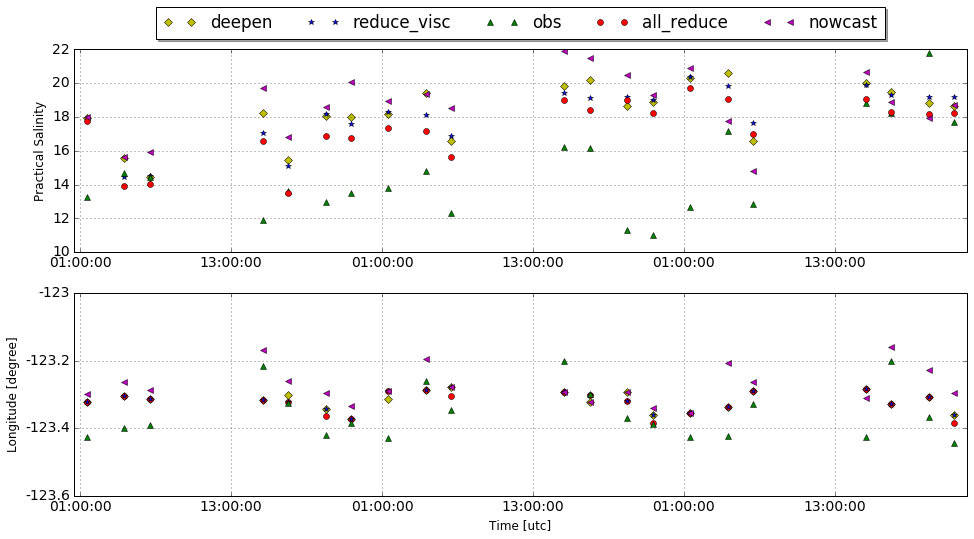

In [37]:
mpl.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(2,1,figsize = [16,8])
axs[0].plot(tt,sal_deep[:-1],'yD',label = 'deepen')
axs[0].plot(tt,sal_redu[:-1],'b*',label = 'reduce_visc')
axs[0].plot(tt,sal_min_obs[:-1],'g^',label = 'obs')
axs[0].plot(tt,sal_allredu[:-1],'ro',label = 'all_reduce')
axs[0].plot(tt,sal_now[:-1],'m<',label = 'nowcast')
axs[0].set_ylabel('Practical Salinity', fontsize= 12)

axs[1].plot(tt,lon_deep[:-1],'yD',label = 'deepen')
axs[1].plot(tt,lon_allredu[:-1],'ro',label = 'all_reduce')
axs[1].plot(tt,lon_redu[:-1],'b*',label = 'reduce_visc')
axs[1].plot(tt,lon_obs[:-1],'g^',label = 'obs')
axs[1].plot(tt,lon_now[:-1],'m<',label = 'nowcast')
axs[1].set_ylabel('Longitude [degree]', fontsize= 12)
axs[1].set_ylim(-123.6, -123)
axs[1].set_yticks([-123.6, -123.4, -123.2,-123])
axs[1].set_yticklabels([-123.6, -123.4, -123.2,-123])
axs[1].set_xlabel('Time [utc]', fontsize= 12)
for ax in axs:
    #ax.legend(loc = 'best', fontsize= 14)   
    ax.set_xlim(tt[0],tt[-1])
    ax.grid('on')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=False, shadow=True)

# River channel image

In [91]:
# This is a copy of the viz_tools function for making this demo more self-contained.  

def set_aspect(
    axes,
    aspect=5/4.4,
    coords='grid',
    lats=None,
    adjustable='box-forced',
):
    """Set the aspect ratio for the axes.

    This is a thin wrapper on the :py:meth:`matplotlib.axes.Axes.set_aspect`
    method.
    Its primary purpose is to free the user from needing to remember the
    5/4.4 nominal aspect ratio for the Salish Sea NEMO model grid,
    and the formula for the aspect ratio based on latitude for map
    coordinates.
    It also sets the axes aspect ratio with :py:attr:`adjustable='box-forced'`
    so that the axes can be shared if desired.

    :arg axes: Axes instance to set the aspect ratio of.
    :type axes: :py:class:`matplotlib.axes.Axes`

    :arg aspect: Aspect ratio.
    :type aspect: float

    :arg coords: Type of plot coordinates to set the aspect ratio for;
                 either :kbd:`grid` (the default) or :kbd:`map`.
    :type coords: str

    :arg lats: Array of latitude values to calculate the aspect ratio
                    from; only required when :kbd:`coordinates='map'`.
    :type lats: :py:class:`numpy.ndarray`

    :arg adjustable: How to adjust the axes box.
    :type adjustable: str

    :returns: Aspect ratio.
    :rtype: float

    .. note::

        To explicitly set the aspect ratio for map coordinates
        (instead of calculating it from latitudes)
        set :kbd:`aspect` to the aspect ratio,
        :kbd:`coords='map'`,
        and use the default :kbd:`lats=None`.
    """
    if coords == 'map' and lats is not None:
        aspect = 1 / np.cos(np.median(lats) * np.pi / 180)
    axes.set_aspect(aspect, adjustable=adjustable)
    return aspect

In [105]:
def plot_colourmesh(
    dataset1,
    dataset2,
    axis_limits=None,
    colour_map='winter_r',
    bins=15,
    land_colour='#edc9af',
):
    """Create a colour-mesh plot of a bathymetry dataset
    on a longitude/latitude axis.

    :arg dataset: netcdf dataset object containing the bathymetry
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg title: Title for the plot
    :type title: str

    :arg fig_size: Size of the figure
    :type fig_size: 2-tuple

    :arg axis_limits: Axis limits for the plt (xmin, xmax, ymin, ymax);
                      defaults to those calculated by :py:obj:`matplotlib`
    :type axis_limits: 4-tuple

    :arg colour_map: :py:obj:`matplotlib` colour map name
    :type colour_map: str

    :arg bins: Number of level bins for the colour map
    :type bins: int

    :arg land_colour: Colour to use for land regions;
                      i.e. those which the depth is undefined in the
                      dataset's :py:const:`Bathymetry` variable masked array
    :type land_colour: str

    :returns: Figure object containing the plot
    :rtype: :py:class:`matplotlib.figure.Figure`
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 9))
    ax1.set_position((0.125, 0.225, 0.7, 0.775))
    ax2.set_position((0.9, 0.225, 0.7, 0.775))
    #ax3.set_position((0.475, 0.05, 0.775, 0.05))
    
    ax=ax1
    lats = dataset1.variables['nav_lat']
    lons = dataset1.variables['nav_lon']
    depths = dataset1.variables['Bathymetry']
    set_aspect(ax)
    cmap, norm = bathy_tools.prep_colour_map(
        depths, limits=(0, np.max(depths)), colour_map=colour_map, bins=bins)
    cmap.set_bad(land_colour)
    ax.pcolormesh(lons[:], lats[:], depths[:], cmap=cmap, norm=norm)
    if axis_limits is not None:
        ax.axis(axis_limits)
    #bathy_tools.set_aspect_ratio(lats)
    
    ax = ax2;
    lats = dataset2.variables['nav_lat']
    lons = dataset2.variables['nav_lon']
    depths = dataset2.variables['Bathymetry']
    #bathy_tools.set_aspect_ratio(lats)
    set_aspect(ax)
    cmap, norm = bathy_tools.prep_colour_map(
        depths, limits=(0, np.max(depths)), colour_map=colour_map, bins=bins)
    cmap.set_bad(land_colour)
    mesh = ax.pcolormesh(lons[:], lats[:], depths[:], cmap=cmap, norm=norm)
    cbar = fig.colorbar(mesh,orientation='horizontal')
    cbar.set_label('Depth [m]')
    if axis_limits is not None:
        ax.axis(axis_limits)
    #for dataset, ax in zip(datas,axs):
        #lats = dataset.variables['nav_lat']
        #lons = dataset.variables['nav_lon']
        #depths = dataset.variables['Bathymetry']
        #bathy_tools.set_aspect_ratio(lats)
        #cmap, norm = bathy_tools.prep_colour_map(
            #depths, limits=(0, np.max(depths)), colour_map=colour_map, bins=bins)
        #cmap.set_bad(land_colour)
        #mesh = ax.pcolormesh(lons[:], lats[:], depths[:], cmap=cmap, norm=norm)
        #if ax ==axs[1]:
            #cbar = fig.colorbar(mesh,orientation='horizontal')
            #cbar.set_label('Depth [m]')
    #if axis_limits is not None:
        #plt.axis(axis_limits)
    #cbar = plt.colorbar( orientation='horizontal')
    #cbar.set_label('Depth [m]')
    return fig

In [22]:
bathy_6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r' )
bathyy_6 = bathy_6.variables['Bathymetry']
lon_6 = bathy_6.variables['nav_lon']
lat_6 = bathy_6.variables['nav_lat']

In [23]:
bathy_2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc','r' )
bathyy_2 = bathy_2.variables['Bathymetry']
lon_2 = bathy_2.variables['nav_lon']
lat_2 = bathy_2.variables['nav_lat']

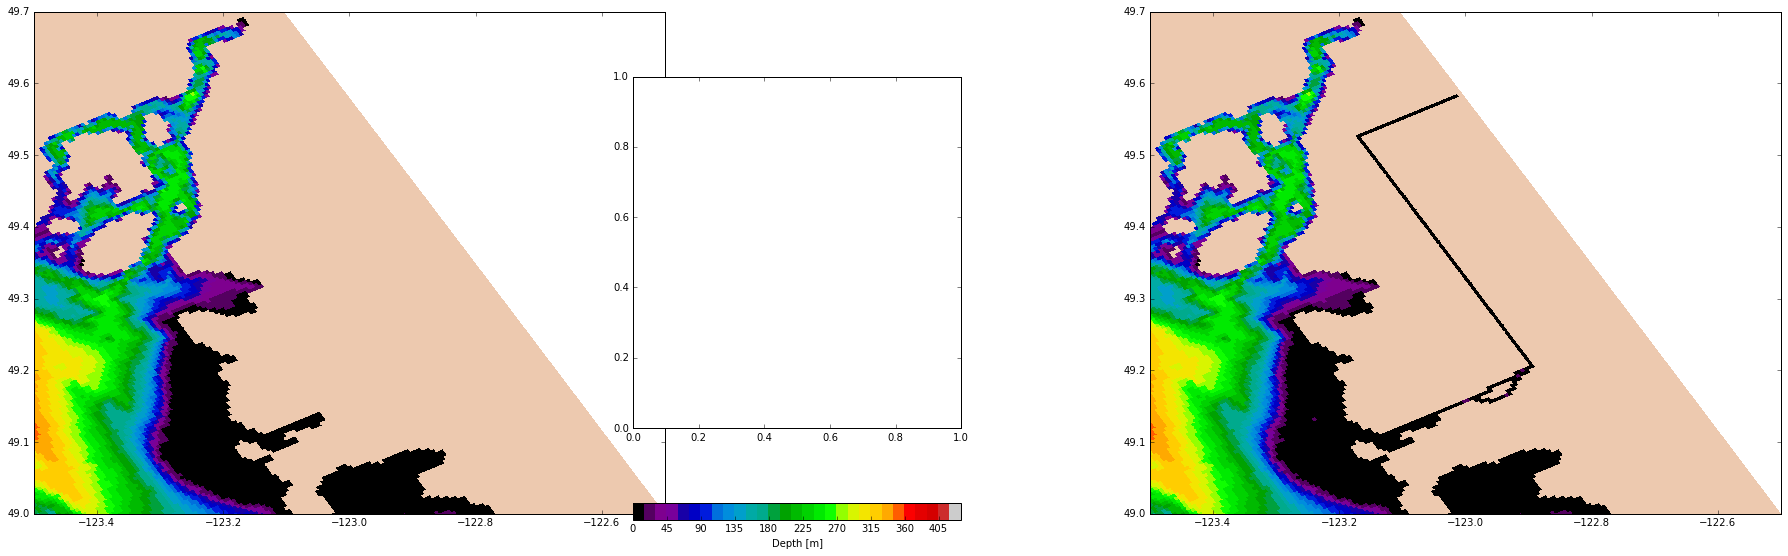

In [106]:
fig = plot_colourmesh(
    bathy_2,bathy_6, 
    axis_limits=(-123.5, -122.5, 49., 49.7), colour_map='spectral', bins=30)

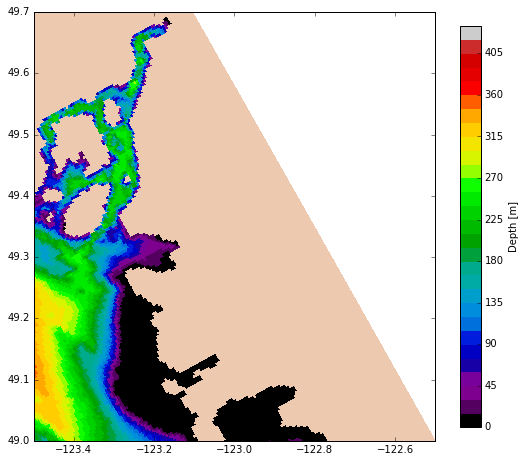

In [18]:
fig = plot_colourmesh(
    bathy_2, 
    axis_limits=(-123.5, -122.5, 49., 49.7), colour_map='spectral', bins=30)

# Viscosity & Diffusivity

In [12]:
SITES = {
    'VENUS East':{
        'lat' : 49.0419,
        'lon' : -123.3176,
        'depth' : 170,
        'i' : 416,
        'j' : 283
    },    
    'VENUS Central': {
        'lat': 49.0401,
        'lon': -123.4261,
        'depth' : 300,
        'i': 424,
        'j': 266
        },
        }

In [13]:
runs=['oct8_101e061e05','oct8_10test1e-04']
base='/data/jieliu/MEOPAR/river-treatment/'
sals={}; depths={}; avms={}; avds={}; Ws={};depthws={}; Us={}; Vs={}
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
bathy=grid.variables['Bathymetry']
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline']
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat']
    T_lon = f.variables['nav_lon']

    #Loading eddy viscosity/diffusivity data on the vertical grid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_W.nc'.format(run))
    f = nc.Dataset(path,'r');
    avms[run]=f.variables['ve_eddy_visc']
    avds[run]= f.variables['ve_eddy_diff'] #
    Ws[run]=f.variables['vovecrtz']
    depthws[run] = f.variables['depthw']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']

In [18]:
def compare_visc_diff(j, i,station,zmin=0, zmax=50, xmin=-7,xmax=-2):
    """Compare vertical eddy diff and viscosity at time t and gridpoint (i,j)"""
    
    colors=['b','g']
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    for run, c in zip(runs, colors):
        #diff
        title = ' Diffusivity averaged over 3 days - {}'.format( station )
        ax=axs[0]
        avd=avds[run][:,:,j,i]
        avd=np.nanmean(np.ma.masked_values(avd,0),axis=0)
        ax.plot(np.log10(avd),depthws[run],'-o',label=run,color=c)
        ax.plot(np.log10([bg[run]['diff'], bg[run]['diff']]), [depthws[run][0], depthws[run][-1]],
                '--', color=c, label='background')
        ax.set_xlabel('Log base 10 of diffusivity (m^2/s)')
        ax.set_title(title)
        
        #visc
        title = ' Viscosity averaged over 3 days - {}'.format(station )
        ax=axs[1]
        avm=avms[run][:,:,j,i]
        avm=np.nanmean(np.ma.masked_values(avm,0),axis=0)
        ax.plot(np.log10(avm),depthws[run],'-o',label=run,color=c)
        ax.plot(np.log10([bg[run]['visc'], bg[run]['visc']]), [depthws[run][0], depthws[run][-1]],
                '--', color=c, label='background')
        ax.set_xlabel('Log base 10 of Viscosity (m^2/s)')
        ax.set_title(title)

    for ax in axs:
        ax.legend(loc=0)
        ax.set_ylabel('Depth [m]')
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([zmax,zmin])
        ax.grid('on')
    
    return fig

In [19]:
bg = {runs[0]: {'visc': 1e-5, 'diff': 1e-6},
      runs[1]: {'visc': 1e-4, 'diff': 1e-5}
      }

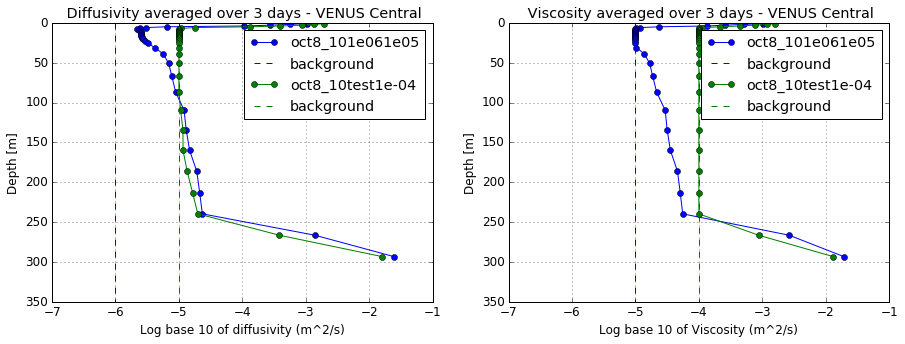

In [20]:
site='VENUS Central'
mpl.rcParams.update({'font.size': 12})
mpl.rcParams["axes.formatter.useoffset"] = False
fig =compare_visc_diff(SITES[site]['i'], SITES[site]['j'],site, zmin=0, zmax=350,xmin=-7,xmax=-1)